# Setting up the Environment

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

## Tensorflow Imports

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

# Setup Data
Here we format the data to be suitable for use by the model
- periodic data
- nonperiodic grouped data

# Incomes

In [39]:
def parse_expense(file_path):
  expenses = pd.read_csv(file_path)
  # Split periodic and non-periodic expenses
  expenses_periodic = expenses[expenses['periodicity'] != 'none']
  expenses_nonperiodic = expenses[expenses['periodicity'] == 'none']
  # Convert date to datetime to be able to group by month
  expenses_nonperiodic['date'] = pd.to_datetime(expenses_nonperiodic['date'])
  # Create new dataframe with headers
  expenses_nonperiodic_grouped = pd.DataFrame({
    **{'date': []}, 
    **{category: [] for category in expenses_nonperiodic['category'].unique()}})
  # Store accumulated amount for each month
  sum = 0
  prev_month = None
  for date in sorted(expenses_nonperiodic["date"].unique()):
    # Get month and year
    month = date.month
    year = date.year
    # Store month and year
    m = (month, year)
    if prev_month == None or m != prev_month:
      sum = 0
      prev_month = m
    # Transpose to have categories as columns
    temp = expenses_nonperiodic[expenses_nonperiodic["date"] == date].groupby(["category"]).agg({'amount': 'sum'})
    temp = temp.transpose()
    temp['total'] = temp.sum(axis=1) + sum
    sum = temp['total']
    temp['date'] = date
    expenses_nonperiodic_grouped = pd.concat([expenses_nonperiodic_grouped, temp])

  expenses_nonperiodic_grouped = expenses_nonperiodic_grouped.set_index('date')
  expenses_nonperiodic_grouped = expenses_nonperiodic_grouped.fillna(0)
  # TODO: Add periodic expenses
  return expenses_nonperiodic_grouped

<Axes: xlabel='date'>

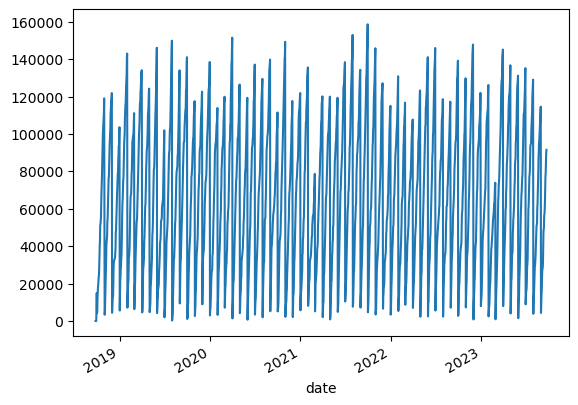

In [40]:
expenses = parse_expense('../data/transactions/expenses.csv')
expenses['total'].plot()
#incomes_nonperiodic_grouped['total'].plot()

# Expenses

In [41]:
def parse_incomes(file_path):
  incomes_df = pd.read_csv(file_path)
  # Split periodic and non-periodic incomes
  incomes_periodic = incomes_df[incomes_df['periodicity'] != 'none']
  incomes_nonperiodic = incomes_df[incomes_df['periodicity'] == 'none']
  # Convert date to datetime to be able to group by month
  incomes_nonperiodic['date'] = pd.to_datetime(incomes_nonperiodic['date'])
  incomes_nonperiodic_grouped = pd.DataFrame()
  # Store accumulated amount for each month
  sum = 0
  prev_month = None
  for date in sorted(incomes_nonperiodic["date"].unique()):
    # Get month and year
    year = date.year
    month = date.month
    # Store month and year
    m = (month, year)
    if prev_month == None or m != prev_month:
      sum = 0
      prev_month = m
    # Compute total
    total = incomes_nonperiodic[incomes_nonperiodic["date"] == date]['amount'].sum() + sum
    temp = pd.DataFrame({
        'total': [total],
        'date': [date]
    })
    sum = total
    incomes_nonperiodic_grouped = pd.concat([incomes_nonperiodic_grouped, temp])

  incomes_nonperiodic_grouped = incomes_nonperiodic_grouped.set_index('date')
  incomes_nonperiodic_grouped = incomes_nonperiodic_grouped.fillna(0)
  return incomes_nonperiodic_grouped

<Axes: xlabel='date'>

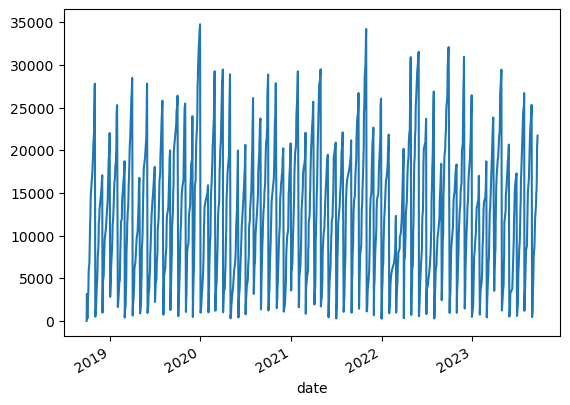

In [42]:
incomes = parse_incomes('../data/transactions/income.csv')
incomes['total'].plot()
#expenses_nonperiodic_grouped['total'].plot()

# Regression (expenses)

In [28]:
def loss_mse_warmup(y_true, y_pred, warmup_steps = 50):
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    mse = mean(square(y_true_slice - y_pred_slice))

    return mse

In [46]:
def train_model(target, df, path_checkpoint, batch_size = 30, sequence_length = 500):
  tm_shift = 15

  df_targets = df[target].shift(-tm_shift)

  x_data = df.values[0:-tm_shift]
  y_data = df_targets.values[:-tm_shift]

  train_split = 0.8

  train_samples = int(train_split * len(x_data))

  x_train = x_data[0:train_samples]
  x_test = x_data[train_samples:]

  y_train = y_data[0:train_samples]
  y_test = y_data[train_samples:]

  x_scaler = MinMaxScaler()
  x_train_scaled = x_scaler.fit_transform(x_train)
  x_test_scaled = x_scaler.transform(x_test)

  y_scaler = MinMaxScaler()
  y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
  y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

  def batch_generator(batch_size, sequence_length):
    while True:
        x_shape = (batch_size, sequence_length, x_data.shape[1])
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, y_data.reshape(-1,1).shape[1])
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(train_samples - sequence_length)

            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]

        yield (x_batch, y_batch)

  generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

  x_batch, y_batch = next(generator)

  batch = 0   # First sequence in the batch.
  signal = 0  # First signal from the 20 input-signals.
  seq = x_batch[batch, :, signal]
  plt.plot(seq)

  seq = y_batch[batch, :, signal]
  plt.plot(seq)

  validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

  model = Sequential()

  print(x_data.shape[1])

  model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, x_data.shape[1],)))

  model.add(Dense(y_data.reshape(-1,1).shape[1], activation='sigmoid'))

  optimizer = RMSprop(lr=1e-3)
  model.compile(loss=loss_mse_warmup, optimizer=optimizer)

  callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

  callback_early_stopping = EarlyStopping(monitor='val_loss',
                                          patience=5, verbose=1)

  callback_tensorboard = TensorBoard(log_dir='./logs/',
                                    histogram_freq=0,
                                    write_graph=False)

  callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.1,
                                        min_lr=1e-4,
                                        patience=0,
                                        verbose=1)

  callbacks = [callback_early_stopping,
              callback_checkpoint,
              callback_tensorboard,
              callback_reduce_lr]

  model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

  try:
    model.load_weights(path_checkpoint)
  except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

  result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

  if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

  x = x_train_scaled
  y_true = y_train

  x = np.expand_dims(x, axis=0)

  y_pred = model.predict(x)

      # The output of the model is between 0 and 1.
      # Do an inverse map to get it back to the scale
      # of the original data-set.
  y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

  signal_pred = y_pred_rescaled
  signal_true = y_true
  plt.figure(figsize=(15,5))
  plt.plot(signal_true, label='true')
  plt.plot(signal_pred, label='pred')
  p = plt.axvspan(0, 50, facecolor='black', alpha=0.15)
  plt.ylabel(target)
  plt.legend()
  plt.show()

  return signal_pred[-1]

In [45]:
expected_expenses = train_model('total', expenses, 'expenses_regression_checkpoint.keras')

(1672, 8) (1672,)


In [10]:
expected_expenses

array([14655.261], dtype=float32)

Epoch 1/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0462
Epoch 1: val_loss improved from inf to 0.04622, saving model to incomes_regression_checkpoint.keras
100/100 [==============================] - 8s 57ms/step - loss: 0.0462 - val_loss: 0.0462 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0427
Epoch 2: val_loss improved from 0.04622 to 0.04237, saving model to incomes_regression_checkpoint.keras
100/100 [==============================] - 5s 51ms/step - loss: 0.0427 - val_loss: 0.0424 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0319
Epoch 3: val_loss improved from 0.04237 to 0.02689, saving model to incomes_regression_checkpoint.keras
100/100 [==============================] - 5s 52ms/step - loss: 0.0319 - val_loss: 0.0269 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0272
Epoch 4: val_loss improved from 0.02689 to 0.02609, saving model to incomes

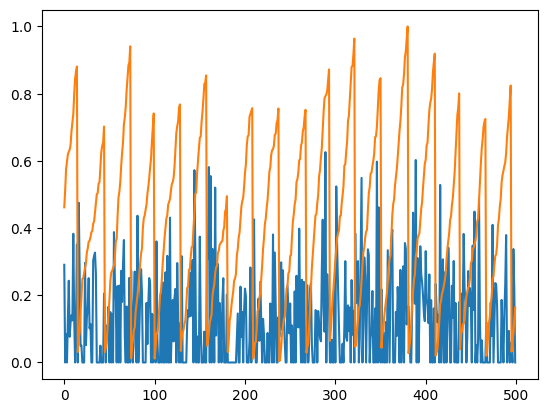

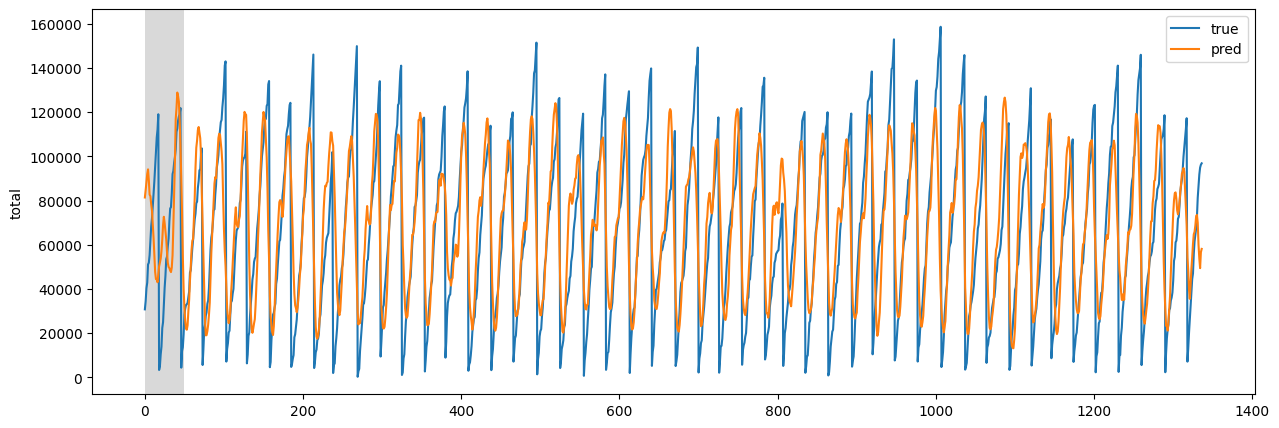

In [11]:
expected_incomes = train_model('total', incomes_nonperiodic_grouped, 'incomes_regression_checkpoint.keras')

In [12]:
expected_incomes

array([58148.33], dtype=float32)

In [ ]:
# Use model

In [47]:
def predict():
    model = Sequential()
    model.load_weights('expenses_regression_checkpoint.keras')

predict()

ValueError: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.